In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from sklearn.model_selection import train_test_split



# Import Keras
import keras as K
from keras.models import load_model, Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.applications import Xception, ResNet50V2
from keras.applications.xception import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.losses import CategoricalCrossentropy


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
train = unpickle("cifar-100-python\\train")
test = unpickle("cifar-100-python\\test")
meta = unpickle("cifar-100-python\\meta")

In [6]:
print(train[b'data'].shape)

(50000, 3072)


In [7]:
def display_rd_img(dataset):
    load = dataset[b'data']
    num = rd.randint(0, len(load))
    title = str(dataset[b'filenames'][num])
    title = title.split("\'")[1].split("_s_")[0]
    img = load[num]
    img = img.reshape((3,32,32))
    img = img.transpose(1,2,0)
    print(type(img))
    plt.imshow(img)
    plt.title(title)


<class 'numpy.ndarray'>


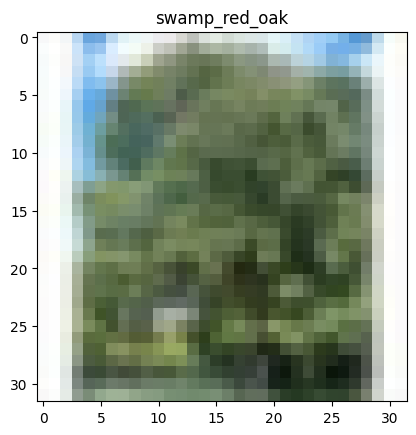

In [8]:
display_rd_img(train)

In [9]:
def pre_process(dataset):
    data = dataset[b'data']
    result = []
    for i in range(0, len(data)):
        temp = data[i].reshape((3,32,32))
        temp= temp.transpose(1,2,0)
        result.append(temp)
    return result

p_train = pre_process(train)    

In [10]:
trained_label = train[b'fine_labels']

In [11]:
print(len(p_train))

50000


In [12]:
class CIFAR100Generator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=32, shuffle=True, num_classes=100, augment=False):
        self.images = np.array(images, dtype=np.float32) 
        self.labels = np.array(labels, dtype=np.int32)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.augment = augment  # Activation ou non de l'augmentation
        self.indices = np.arange(len(self.images))
        self.images = preprocess_input(self.images)  
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.images) // self.batch_size  # Nombre total de batchs par epoch

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_labels = self.labels[batch_indices]

        # Convertir les labels en one-hot encoding
        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)

        # Appliquer l'augmentation uniquement pour l'entraînement
        if self.augment:
            batch_images = self.augment_images(batch_images)

        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def augment_images(self, batch_images):
        batch_images_aug = []
        for img in batch_images:
            if np.random.rand() > 0.5:  # 50% des images restent inchangées
                batch_images_aug.append(img)
            else:
                img = tf.image.random_flip_left_right(img)
                img = tf.image.random_brightness(img, max_delta=0.2)
                img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
                img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
                img = tf.image.rot90(img, k=np.random.randint(4))
                img = tf.image.resize_with_crop_or_pad(img, 36, 36)
                img = tf.image.random_crop(img, size=[32, 32, 3])
                batch_images_aug.append(img)
        
        return np.array(batch_images_aug, dtype=np.float32)



def create_generators(images, labels, batch_size=32, val_split=0.2):
    """
    Sépare les données en train/val et retourne deux générateurs.
    """
    # Séparation des données en train et validation
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=val_split, random_state=42)

    # Création des générateurs
    train_generator = CIFAR100Generator(X_train, y_train, batch_size=batch_size, shuffle=True, augment=True)  # Augmentation activée
    val_generator = CIFAR100Generator(X_val, y_val, batch_size=batch_size, shuffle=False, augment=False)  # Pas d'augmentation pour validation
    
    return train_generator, val_generator



def create_test_generator(images, labels, batch_size=32):
    # Création des générateurs
    test_generator = CIFAR100Generator(images, labels, batch_size=batch_size, shuffle=False, augment=False)  # Pas d'augmentation pour validation
    
    return test_generator


In [13]:
train_generator, val_generator = create_generators(p_train, trained_label, batch_size=64)

In [14]:

x_batch, y_batch = train_generator[0]
print("Shape des images:", x_batch.shape)  # Doit être (batch_size, 32, 32, 3)
print("Shape des labels:", y_batch.shape)  # Doit être (batch_size, 100)


Shape des images: (64, 32, 32, 3)
Shape des labels: (64, 100)


In [15]:
class HardExampleMining(Callback):
    def __init__(self, train_generator, percentile=50):
        super(HardExampleMining, self).__init__()
        self.train_generator = train_generator  # Générateur de données
        self.percentile = percentile  # Seuil pour les hard examples
        self.loss_fn = CategoricalCrossentropy()

    def on_epoch_end(self, epoch, logs=None):
        print(f"\n🔍 Analyse des hard examples après l'époque {epoch}...")

        X_train, y_train = [], []
        for i in range(len(self.train_generator)):
            X_batch, y_batch = self.train_generator[i]
            X_train.append(X_batch)
            y_train.append(y_batch)

        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)

        y_pred = self.model.predict(X_train, verbose=0)
        losses = K.losses.categorical_crossentropy(y_train, y_pred).numpy()

        # ✅ Correction : Ne pas enlever trop d'exemples
        threshold = np.percentile(losses, self.percentile)
        hard_indices = np.where(losses > threshold)[0]

        # ✅ Si aucun exemple n'est sélectionné, prendre les 10% pires
        if len(hard_indices) == 0:
            hard_indices = np.argsort(losses)[-max(10, len(losses) // 10):]

        print(f"📌 {len(hard_indices)} exemples sélectionnés (seuil = {threshold:.4f})")

        print(f"🔍 Analyse des prédictions après l'époque {epoch}:")
        print(f"  - Probabilité moyenne max : {np.mean(np.max(y_pred, axis=1)):.4f}")
        print(f"  - Écart-type des probas max : {np.std(np.max(y_pred, axis=1)):.4f}")


        plt.hist(losses, bins=30)
        plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)
        plt.xlabel("Valeur de la perte")
        plt.ylabel("Nombre d'exemples")
        plt.title("Distribution des pertes")
        plt.show()




In [16]:
def neural_net(num_neurones,num_hidden_layers,dropout_rate, early_stop_patience, lr_scheduler_patience, train_generator,learning_rate= 0.0001):
    #base_model = Xception(weights='imagenet', include_top=False)
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(32,32,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x) 
    # Ajouter des couches personnalisées
    for _ in range (0, num_hidden_layers): 
        x = Dense(num_neurones, activation='relu')(x)  # Ajouter une couche Dense pour l'apprentissage des caractéristiques
        #x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)  # Ajouter une couche de dropout pour réduire le surapprentissage
    predictions = Dense(100, activation='softmax')(x)  # Couche de sortie pour 100 classes

    # Configurer les callbacks
    checkpoint = ModelCheckpoint("test.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stop_patience, verbose=1, mode='auto')
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=lr_scheduler_patience)
    hardExample = HardExampleMining(train_generator)  # Ajout du callback Hard Example Mining
    callbacks = [checkpoint, early, lr_scheduler, hardExample]

    # Créer l'instance de l'optimiseur avec le learning rate spécifié
    optimizer = Adam(learning_rate=learning_rate)
    #optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)


    # Compiler le modèle avec l'optimiseur configuré
    model = Model(inputs= base_model.input , outputs=predictions)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
    return model, callbacks

# Entraîner le modèle
def training(model, cb, n_epoch):
    history = model.fit(
        train_generator,
        epochs=n_epoch,
        validation_data=val_generator,
        callbacks=cb)
    
    model.save('test_final.h5')
    return history

def plot_history(history):
    # Tracer la précision et la perte
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Epoch 1/200
625/625 [==============================] - ETA: 0s - loss: 4.6258 - accuracy: 0.0125
Epoch 1: val_loss improved from inf to 4.56527, saving model to test.h5

🔍 Analyse des hard examples après l'époque 0...
📌 19949 exemples sélectionnés (seuil = 4.6043)
🔍 Analyse des prédictions après l'époque 0:
  - Probabilité moyenne max : 0.0174
  - Écart-type des probas max : 0.0566


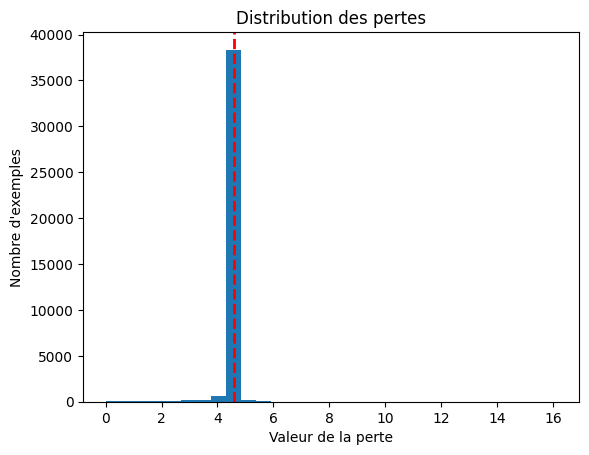

625/625 [==============================] - 202s 309ms/step - loss: 4.6258 - accuracy: 0.0125 - val_loss: 4.5653 - val_accuracy: 0.0263 - lr: 1.0000e-04
Epoch 2/200
625/625 [==============================] - ETA: 0s - loss: 4.5292 - accuracy: 0.0257
Epoch 2: val_loss improved from 4.56527 to 4.41051, saving model to test.h5

🔍 Analyse des hard examples après l'époque 1...
📌 19904 exemples sélectionnés (seuil = 4.5995)
🔍 Analyse des prédictions après l'époque 1:
  - Probabilité moyenne max : 0.0379
  - Écart-type des probas max : 0.0998


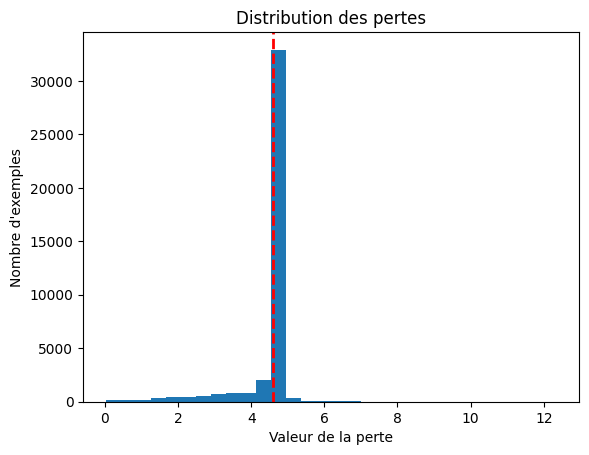

625/625 [==============================] - 187s 300ms/step - loss: 4.5292 - accuracy: 0.0257 - val_loss: 4.4105 - val_accuracy: 0.0360 - lr: 1.0000e-04
Epoch 3/200
625/625 [==============================] - ETA: 0s - loss: 4.4180 - accuracy: 0.0375
Epoch 3: val_loss improved from 4.41051 to 4.28501, saving model to test.h5

🔍 Analyse des hard examples après l'époque 2...
📌 19878 exemples sélectionnés (seuil = 4.5797)
🔍 Analyse des prédictions après l'époque 2:
  - Probabilité moyenne max : 0.0470
  - Écart-type des probas max : 0.1018


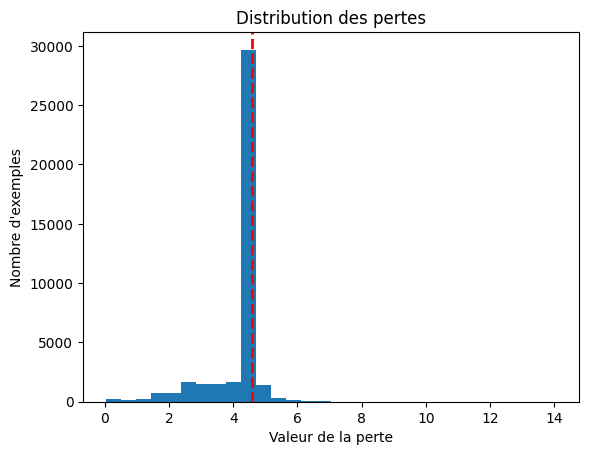

625/625 [==============================] - 205s 329ms/step - loss: 4.4180 - accuracy: 0.0375 - val_loss: 4.2850 - val_accuracy: 0.0613 - lr: 1.0000e-04
Epoch 4/200
625/625 [==============================] - ETA: 0s - loss: 4.2921 - accuracy: 0.0587
Epoch 4: val_loss improved from 4.28501 to 4.08488, saving model to test.h5

🔍 Analyse des hard examples après l'époque 3...
📌 20000 exemples sélectionnés (seuil = 4.4838)
🔍 Analyse des prédictions après l'époque 3:
  - Probabilité moyenne max : 0.0735
  - Écart-type des probas max : 0.1310


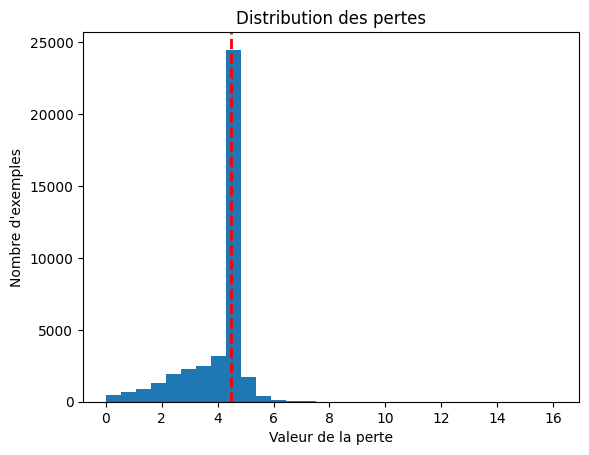

625/625 [==============================] - 198s 317ms/step - loss: 4.2921 - accuracy: 0.0587 - val_loss: 4.0849 - val_accuracy: 0.0889 - lr: 1.0000e-04
Epoch 5/200
625/625 [==============================] - ETA: 0s - loss: 4.1114 - accuracy: 0.0876
Epoch 5: val_loss improved from 4.08488 to 3.81317, saving model to test.h5

🔍 Analyse des hard examples après l'époque 4...
📌 20000 exemples sélectionnés (seuil = 4.1444)
🔍 Analyse des prédictions après l'époque 4:
  - Probabilité moyenne max : 0.1085
  - Écart-type des probas max : 0.1630


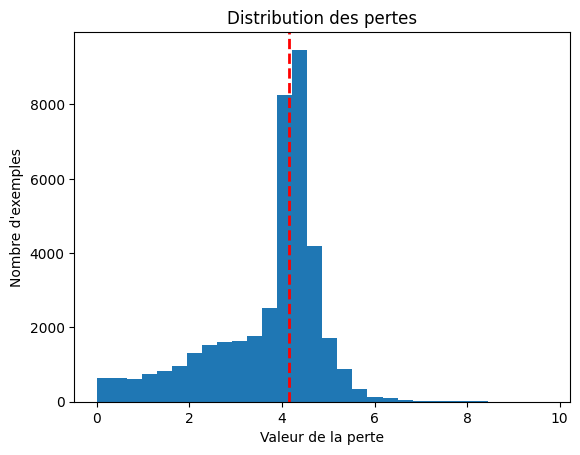

625/625 [==============================] - 229s 366ms/step - loss: 4.1114 - accuracy: 0.0876 - val_loss: 3.8132 - val_accuracy: 0.1372 - lr: 1.0000e-04
Epoch 6/200
625/625 [==============================] - ETA: 0s - loss: 3.9029 - accuracy: 0.1256
Epoch 6: val_loss improved from 3.81317 to 3.55349, saving model to test.h5

🔍 Analyse des hard examples après l'époque 5...
📌 20000 exemples sélectionnés (seuil = 3.8459)
🔍 Analyse des prédictions après l'époque 5:
  - Probabilité moyenne max : 0.1481
  - Écart-type des probas max : 0.1948


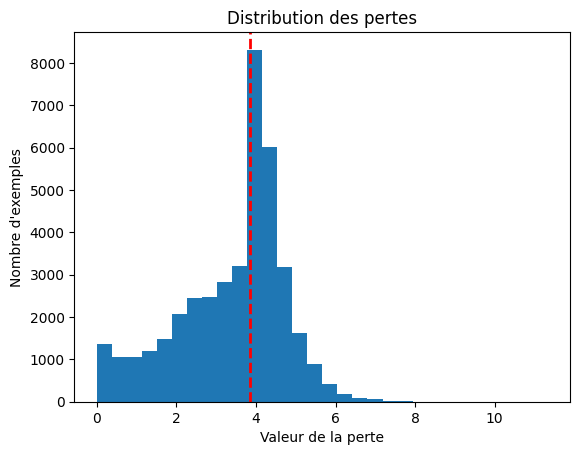

625/625 [==============================] - 274s 438ms/step - loss: 3.9029 - accuracy: 0.1256 - val_loss: 3.5535 - val_accuracy: 0.1858 - lr: 1.0000e-04
Epoch 7/200
625/625 [==============================] - ETA: 0s - loss: 3.7168 - accuracy: 0.1646
Epoch 7: val_loss improved from 3.55349 to 3.38038, saving model to test.h5

🔍 Analyse des hard examples après l'époque 6...
📌 20000 exemples sélectionnés (seuil = 3.5955)
🔍 Analyse des prédictions après l'époque 6:
  - Probabilité moyenne max : 0.1851
  - Écart-type des probas max : 0.2303


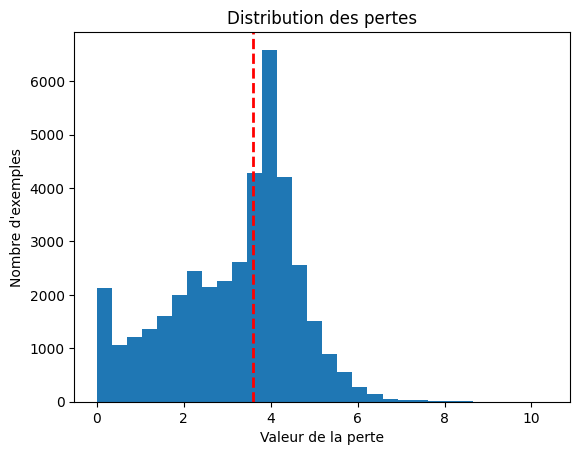

625/625 [==============================] - 279s 446ms/step - loss: 3.7168 - accuracy: 0.1646 - val_loss: 3.3804 - val_accuracy: 0.2369 - lr: 1.0000e-04
Epoch 8/200
625/625 [==============================] - ETA: 0s - loss: 3.5595 - accuracy: 0.2040
Epoch 8: val_loss improved from 3.38038 to 3.24852, saving model to test.h5

🔍 Analyse des hard examples après l'époque 7...
📌 20000 exemples sélectionnés (seuil = 3.2966)
🔍 Analyse des prédictions après l'époque 7:
  - Probabilité moyenne max : 0.2179
  - Écart-type des probas max : 0.2413


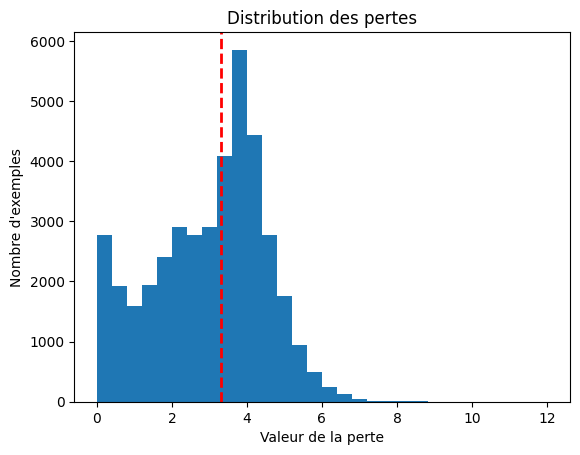

625/625 [==============================] - 234s 374ms/step - loss: 3.5595 - accuracy: 0.2040 - val_loss: 3.2485 - val_accuracy: 0.2687 - lr: 1.0000e-04
Epoch 9/200
625/625 [==============================] - ETA: 0s - loss: 3.4256 - accuracy: 0.2350
Epoch 9: val_loss improved from 3.24852 to 3.15073, saving model to test.h5

🔍 Analyse des hard examples après l'époque 8...
📌 20000 exemples sélectionnés (seuil = 3.1067)
🔍 Analyse des prédictions après l'époque 8:
  - Probabilité moyenne max : 0.2330
  - Écart-type des probas max : 0.2464


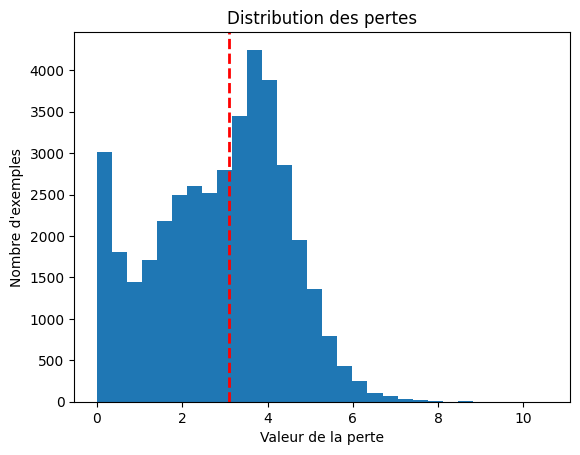

625/625 [==============================] - 213s 340ms/step - loss: 3.4256 - accuracy: 0.2350 - val_loss: 3.1507 - val_accuracy: 0.3039 - lr: 1.0000e-04
Epoch 10/200
625/625 [==============================] - ETA: 0s - loss: 3.3158 - accuracy: 0.2627
Epoch 10: val_loss improved from 3.15073 to 2.98243, saving model to test.h5

🔍 Analyse des hard examples après l'époque 9...
📌 20000 exemples sélectionnés (seuil = 2.7715)
🔍 Analyse des prédictions après l'époque 9:
  - Probabilité moyenne max : 0.2710
  - Écart-type des probas max : 0.2587


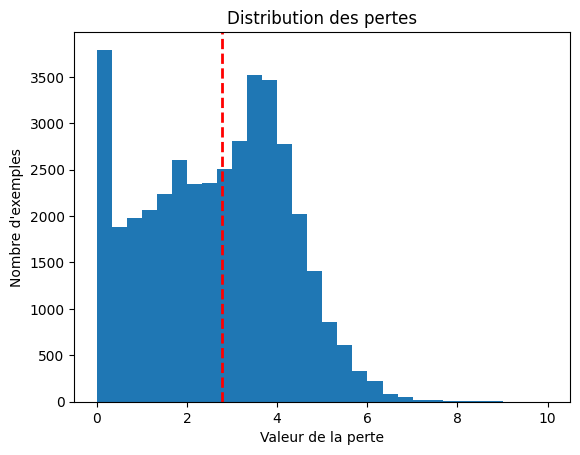

625/625 [==============================] - 204s 327ms/step - loss: 3.3158 - accuracy: 0.2627 - val_loss: 2.9824 - val_accuracy: 0.3428 - lr: 1.0000e-04
Epoch 11/200
625/625 [==============================] - ETA: 0s - loss: 3.1977 - accuracy: 0.2970
Epoch 11: val_loss improved from 2.98243 to 2.90185, saving model to test.h5

🔍 Analyse des hard examples après l'époque 10...
📌 20000 exemples sélectionnés (seuil = 2.6011)
🔍 Analyse des prédictions après l'époque 10:
  - Probabilité moyenne max : 0.3058
  - Écart-type des probas max : 0.2745


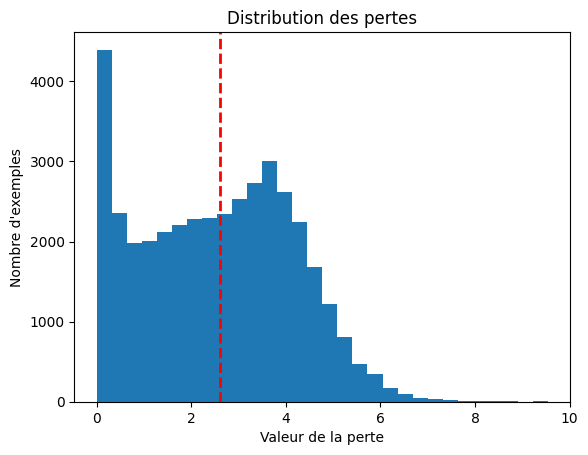

625/625 [==============================] - 222s 356ms/step - loss: 3.1977 - accuracy: 0.2970 - val_loss: 2.9018 - val_accuracy: 0.3613 - lr: 1.0000e-04
Epoch 12/200
625/625 [==============================] - ETA: 0s - loss: 3.1156 - accuracy: 0.3190
Epoch 12: val_loss improved from 2.90185 to 2.83983, saving model to test.h5

🔍 Analyse des hard examples après l'époque 11...
📌 20000 exemples sélectionnés (seuil = 2.3731)
🔍 Analyse des prédictions après l'époque 11:
  - Probabilité moyenne max : 0.3321
  - Écart-type des probas max : 0.2789


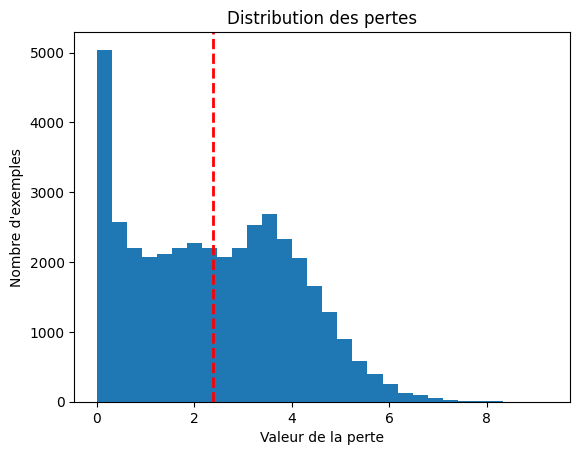

625/625 [==============================] - 222s 355ms/step - loss: 3.1156 - accuracy: 0.3190 - val_loss: 2.8398 - val_accuracy: 0.3784 - lr: 1.0000e-04
Epoch 13/200
625/625 [==============================] - ETA: 0s - loss: 3.0295 - accuracy: 0.3472
Epoch 13: val_loss improved from 2.83983 to 2.79176, saving model to test.h5

🔍 Analyse des hard examples après l'époque 12...
📌 20000 exemples sélectionnés (seuil = 2.2663)
🔍 Analyse des prédictions après l'époque 12:
  - Probabilité moyenne max : 0.3457
  - Écart-type des probas max : 0.2845


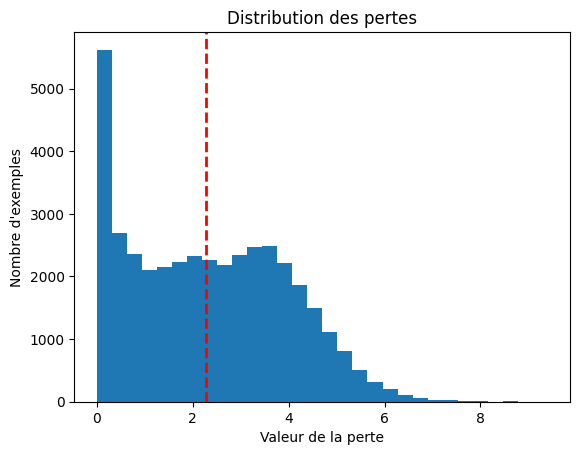

625/625 [==============================] - 217s 348ms/step - loss: 3.0295 - accuracy: 0.3472 - val_loss: 2.7918 - val_accuracy: 0.4021 - lr: 1.0000e-04
Epoch 14/200
625/625 [==============================] - ETA: 0s - loss: 2.9539 - accuracy: 0.3688
Epoch 14: val_loss improved from 2.79176 to 2.71845, saving model to test.h5

🔍 Analyse des hard examples après l'époque 13...
📌 20000 exemples sélectionnés (seuil = 2.0645)
🔍 Analyse des prédictions après l'époque 13:
  - Probabilité moyenne max : 0.3758
  - Écart-type des probas max : 0.2918


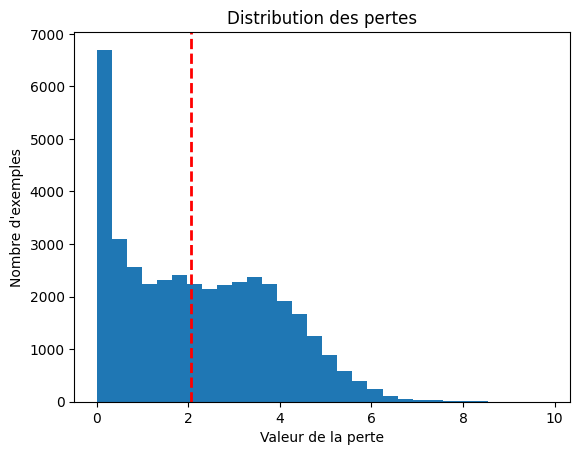

625/625 [==============================] - 219s 350ms/step - loss: 2.9539 - accuracy: 0.3688 - val_loss: 2.7185 - val_accuracy: 0.4215 - lr: 1.0000e-04
Epoch 15/200
625/625 [==============================] - ETA: 0s - loss: 2.8964 - accuracy: 0.3856
Epoch 15: val_loss improved from 2.71845 to 2.68824, saving model to test.h5

🔍 Analyse des hard examples après l'époque 14...
📌 20000 exemples sélectionnés (seuil = 1.9726)
🔍 Analyse des prédictions après l'époque 14:
  - Probabilité moyenne max : 0.3836
  - Écart-type des probas max : 0.2889


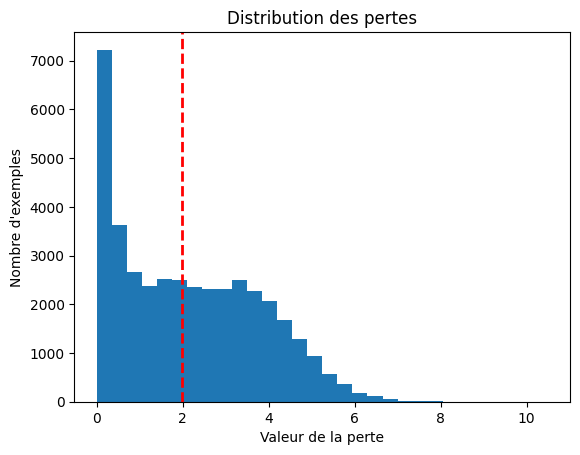

625/625 [==============================] - 219s 351ms/step - loss: 2.8964 - accuracy: 0.3856 - val_loss: 2.6882 - val_accuracy: 0.4309 - lr: 1.0000e-04
Epoch 16/200
625/625 [==============================] - ETA: 0s - loss: 2.8321 - accuracy: 0.4029
Epoch 16: val_loss improved from 2.68824 to 2.66718, saving model to test.h5

🔍 Analyse des hard examples après l'époque 15...
📌 20000 exemples sélectionnés (seuil = 1.8743)
🔍 Analyse des prédictions après l'époque 15:
  - Probabilité moyenne max : 0.4087
  - Écart-type des probas max : 0.3005


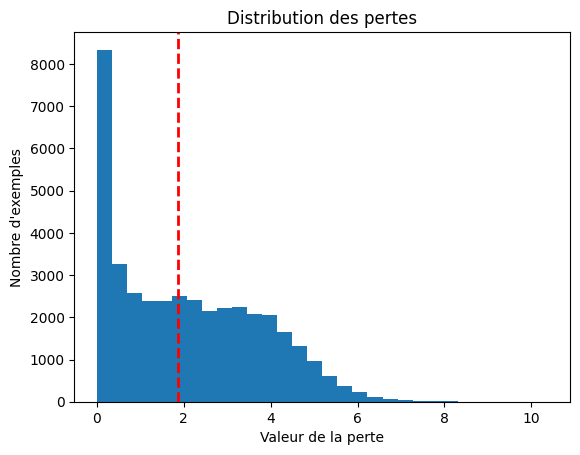

625/625 [==============================] - 227s 363ms/step - loss: 2.8321 - accuracy: 0.4029 - val_loss: 2.6672 - val_accuracy: 0.4395 - lr: 1.0000e-04
Epoch 17/200
625/625 [==============================] - ETA: 0s - loss: 2.7647 - accuracy: 0.4232
Epoch 17: val_loss improved from 2.66718 to 2.62421, saving model to test.h5

🔍 Analyse des hard examples après l'époque 16...
📌 20000 exemples sélectionnés (seuil = 1.7296)
🔍 Analyse des prédictions après l'époque 16:
  - Probabilité moyenne max : 0.4250
  - Écart-type des probas max : 0.2994


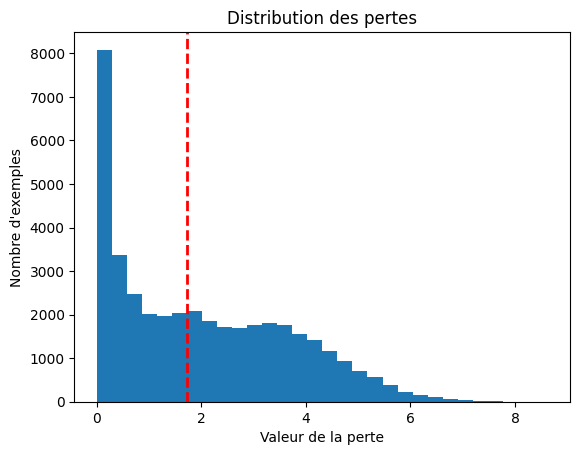

625/625 [==============================] - 236s 378ms/step - loss: 2.7647 - accuracy: 0.4232 - val_loss: 2.6242 - val_accuracy: 0.4518 - lr: 1.0000e-04
Epoch 18/200
625/625 [==============================] - ETA: 0s - loss: 2.7131 - accuracy: 0.4394
Epoch 18: val_loss improved from 2.62421 to 2.61117, saving model to test.h5

🔍 Analyse des hard examples après l'époque 17...
📌 20000 exemples sélectionnés (seuil = 1.6498)
🔍 Analyse des prédictions après l'époque 17:
  - Probabilité moyenne max : 0.4370
  - Écart-type des probas max : 0.2982


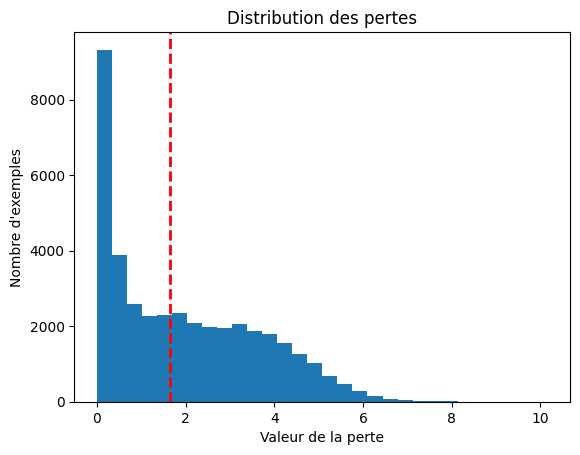

625/625 [==============================] - 209s 334ms/step - loss: 2.7131 - accuracy: 0.4394 - val_loss: 2.6112 - val_accuracy: 0.4599 - lr: 1.0000e-04
Epoch 19/200
625/625 [==============================] - ETA: 0s - loss: 2.6623 - accuracy: 0.4562
Epoch 19: val_loss improved from 2.61117 to 2.58718, saving model to test.h5

🔍 Analyse des hard examples après l'époque 18...
📌 20000 exemples sélectionnés (seuil = 1.5385)
🔍 Analyse des prédictions après l'époque 18:
  - Probabilité moyenne max : 0.4564
  - Écart-type des probas max : 0.3009


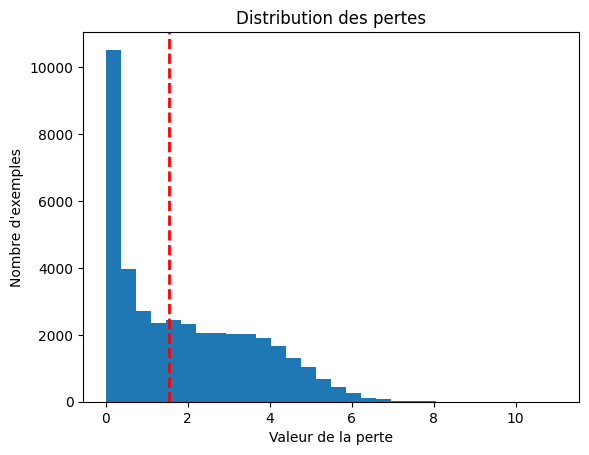

625/625 [==============================] - 233s 373ms/step - loss: 2.6623 - accuracy: 0.4562 - val_loss: 2.5872 - val_accuracy: 0.4675 - lr: 1.0000e-04
Epoch 20/200
625/625 [==============================] - ETA: 0s - loss: 2.6294 - accuracy: 0.4660
Epoch 20: val_loss improved from 2.58718 to 2.58497, saving model to test.h5

🔍 Analyse des hard examples après l'époque 19...
📌 20000 exemples sélectionnés (seuil = 1.4490)
🔍 Analyse des prédictions après l'époque 19:
  - Probabilité moyenne max : 0.4670
  - Écart-type des probas max : 0.3050


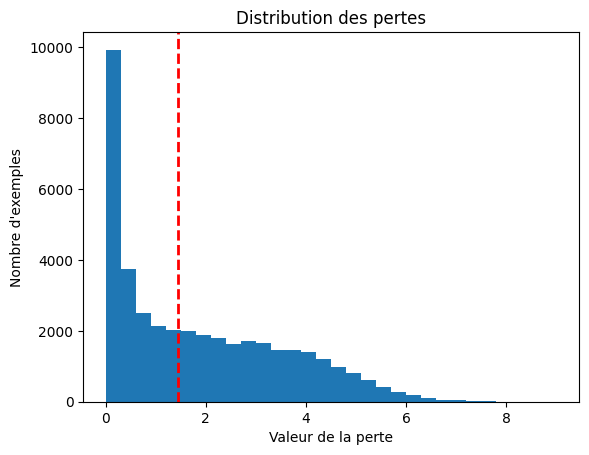

625/625 [==============================] - 227s 363ms/step - loss: 2.6294 - accuracy: 0.4660 - val_loss: 2.5850 - val_accuracy: 0.4637 - lr: 1.0000e-04
Epoch 21/200
625/625 [==============================] - ETA: 0s - loss: 2.5749 - accuracy: 0.4847
Epoch 21: val_loss improved from 2.58497 to 2.55570, saving model to test.h5

🔍 Analyse des hard examples après l'époque 20...
📌 20000 exemples sélectionnés (seuil = 1.3246)
🔍 Analyse des prédictions après l'époque 20:
  - Probabilité moyenne max : 0.4830
  - Écart-type des probas max : 0.3046


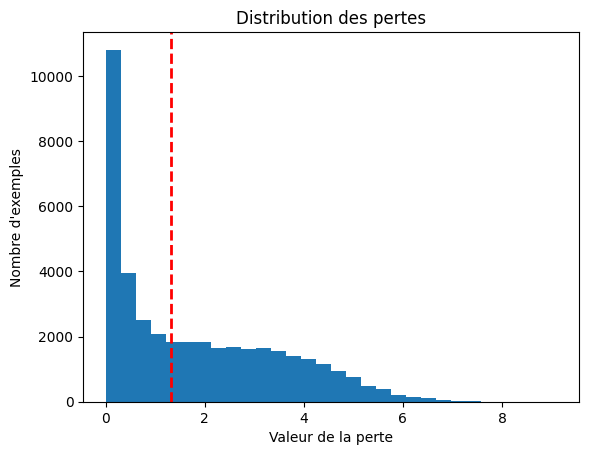

625/625 [==============================] - 237s 380ms/step - loss: 2.5749 - accuracy: 0.4847 - val_loss: 2.5557 - val_accuracy: 0.4756 - lr: 1.0000e-04
Epoch 22/200
625/625 [==============================] - ETA: 0s - loss: 2.5318 - accuracy: 0.4951
Epoch 22: val_loss did not improve from 2.55570

🔍 Analyse des hard examples après l'époque 21...
📌 20000 exemples sélectionnés (seuil = 1.3243)
🔍 Analyse des prédictions après l'époque 21:
  - Probabilité moyenne max : 0.4890
  - Écart-type des probas max : 0.3022


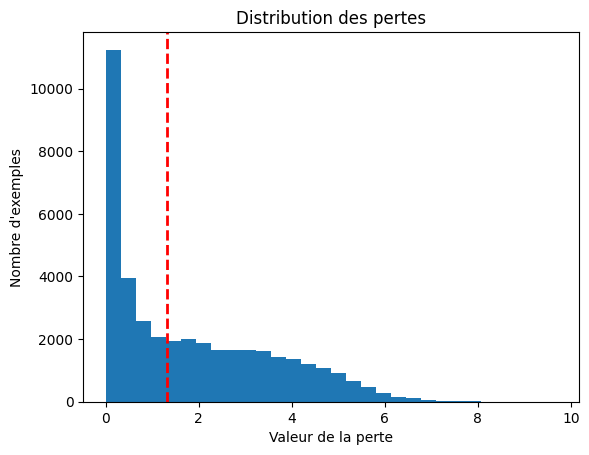

625/625 [==============================] - 231s 369ms/step - loss: 2.5318 - accuracy: 0.4951 - val_loss: 2.5795 - val_accuracy: 0.4774 - lr: 1.0000e-04
Epoch 23/200
625/625 [==============================] - ETA: 0s - loss: 2.4978 - accuracy: 0.5056
Epoch 23: val_loss improved from 2.55570 to 2.52254, saving model to test.h5

🔍 Analyse des hard examples après l'époque 22...
📌 20000 exemples sélectionnés (seuil = 1.1512)
🔍 Analyse des prédictions après l'époque 22:
  - Probabilité moyenne max : 0.5008
  - Écart-type des probas max : 0.3062


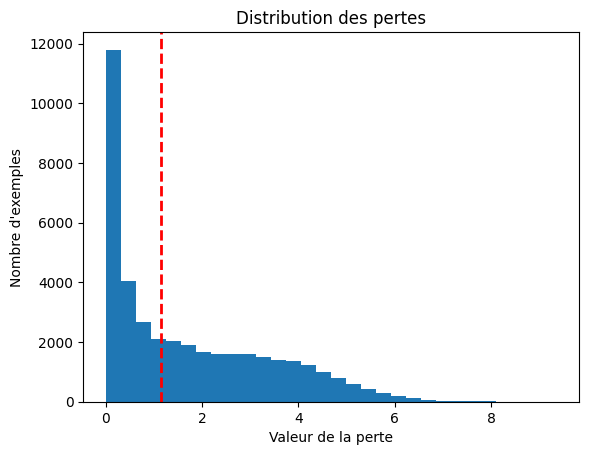

625/625 [==============================] - 239s 383ms/step - loss: 2.4978 - accuracy: 0.5056 - val_loss: 2.5225 - val_accuracy: 0.4867 - lr: 1.0000e-04
Epoch 24/200
625/625 [==============================] - ETA: 0s - loss: 2.4541 - accuracy: 0.5220
Epoch 24: val_loss improved from 2.52254 to 2.50441, saving model to test.h5

🔍 Analyse des hard examples après l'époque 23...
📌 20000 exemples sélectionnés (seuil = 1.0717)
🔍 Analyse des prédictions après l'époque 23:
  - Probabilité moyenne max : 0.5077
  - Écart-type des probas max : 0.3053


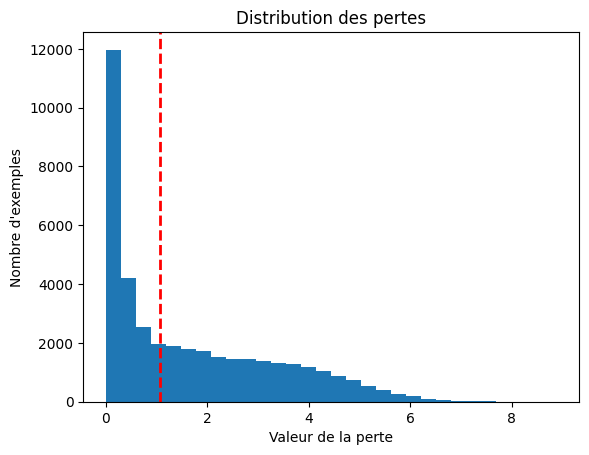

625/625 [==============================] - 231s 369ms/step - loss: 2.4541 - accuracy: 0.5220 - val_loss: 2.5044 - val_accuracy: 0.4933 - lr: 1.0000e-04
Epoch 25/200
625/625 [==============================] - ETA: 0s - loss: 2.4238 - accuracy: 0.5279
Epoch 25: val_loss did not improve from 2.50441

🔍 Analyse des hard examples après l'époque 24...
📌 20000 exemples sélectionnés (seuil = 1.0199)
🔍 Analyse des prédictions après l'époque 24:
  - Probabilité moyenne max : 0.5217
  - Écart-type des probas max : 0.3018


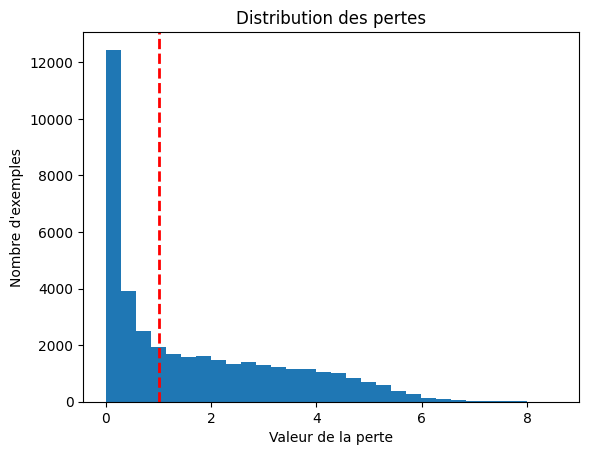

625/625 [==============================] - 232s 372ms/step - loss: 2.4238 - accuracy: 0.5279 - val_loss: 2.5370 - val_accuracy: 0.4876 - lr: 1.0000e-04
Epoch 26/200
625/625 [==============================] - ETA: 0s - loss: 2.3913 - accuracy: 0.5416
Epoch 26: val_loss improved from 2.50441 to 2.49641, saving model to test.h5

🔍 Analyse des hard examples après l'époque 25...
📌 20000 exemples sélectionnés (seuil = 0.9002)
🔍 Analyse des prédictions après l'époque 25:
  - Probabilité moyenne max : 0.5368
  - Écart-type des probas max : 0.3006


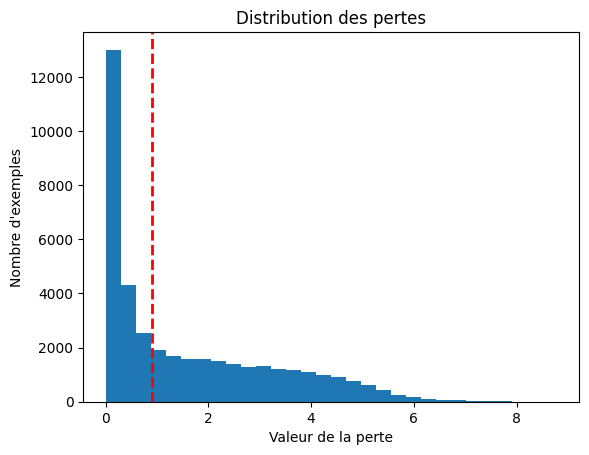

625/625 [==============================] - 235s 375ms/step - loss: 2.3913 - accuracy: 0.5416 - val_loss: 2.4964 - val_accuracy: 0.5008 - lr: 1.0000e-04
Epoch 27/200
625/625 [==============================] - ETA: 0s - loss: 2.3621 - accuracy: 0.5492
Epoch 27: val_loss did not improve from 2.49641

🔍 Analyse des hard examples après l'époque 26...
📌 20000 exemples sélectionnés (seuil = 0.8598)
🔍 Analyse des prédictions après l'époque 26:
  - Probabilité moyenne max : 0.5442
  - Écart-type des probas max : 0.3015


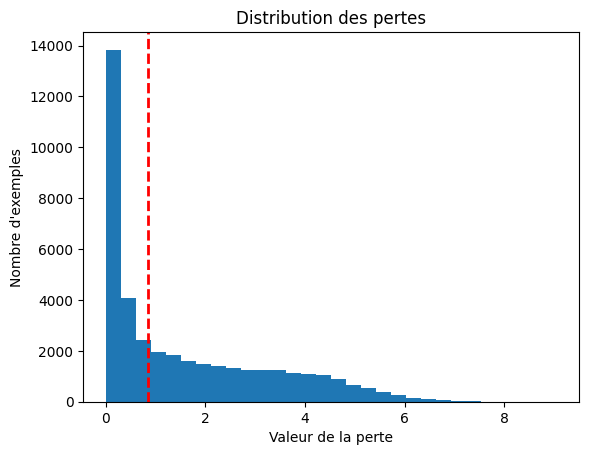

625/625 [==============================] - 226s 361ms/step - loss: 2.3621 - accuracy: 0.5492 - val_loss: 2.5190 - val_accuracy: 0.5008 - lr: 1.0000e-04
Epoch 28/200
625/625 [==============================] - ETA: 0s - loss: 2.3349 - accuracy: 0.5594
Epoch 28: val_loss did not improve from 2.49641

🔍 Analyse des hard examples après l'époque 27...
📌 20000 exemples sélectionnés (seuil = 0.7572)
🔍 Analyse des prédictions après l'époque 27:
  - Probabilité moyenne max : 0.5581
  - Écart-type des probas max : 0.3050


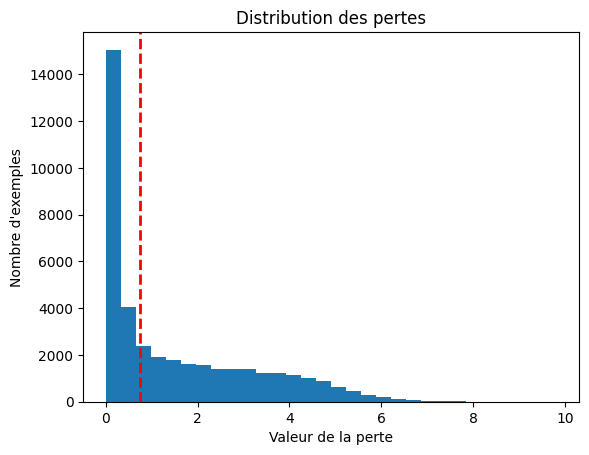

625/625 [==============================] - 231s 370ms/step - loss: 2.3349 - accuracy: 0.5594 - val_loss: 2.4998 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 29/200
625/625 [==============================] - ETA: 0s - loss: 2.3126 - accuracy: 0.5674
Epoch 29: val_loss did not improve from 2.49641

🔍 Analyse des hard examples après l'époque 28...
📌 20000 exemples sélectionnés (seuil = 0.6714)
🔍 Analyse des prédictions après l'époque 28:
  - Probabilité moyenne max : 0.5751
  - Écart-type des probas max : 0.3008


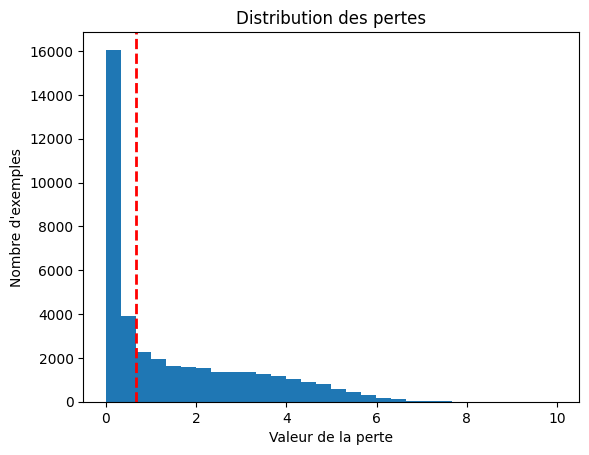

625/625 [==============================] - 233s 373ms/step - loss: 2.3126 - accuracy: 0.5674 - val_loss: 2.5182 - val_accuracy: 0.5048 - lr: 1.0000e-04
Epoch 30/200
625/625 [==============================] - ETA: 0s - loss: 2.2145 - accuracy: 0.5957
Epoch 30: val_loss improved from 2.49641 to 2.43122, saving model to test.h5

🔍 Analyse des hard examples après l'époque 29...
📌 20000 exemples sélectionnés (seuil = 0.5366)
🔍 Analyse des prédictions après l'époque 29:
  - Probabilité moyenne max : 0.5899
  - Écart-type des probas max : 0.3046


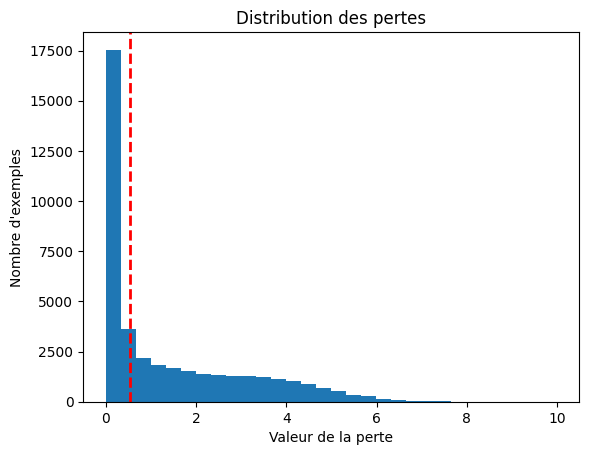

625/625 [==============================] - 240s 383ms/step - loss: 2.2145 - accuracy: 0.5957 - val_loss: 2.4312 - val_accuracy: 0.5194 - lr: 1.0000e-05
Epoch 31/200
625/625 [==============================] - ETA: 0s - loss: 2.1669 - accuracy: 0.6079
Epoch 31: val_loss improved from 2.43122 to 2.42003, saving model to test.h5

🔍 Analyse des hard examples après l'époque 30...
📌 20000 exemples sélectionnés (seuil = 0.4764)
🔍 Analyse des prédictions après l'époque 30:
  - Probabilité moyenne max : 0.5968
  - Écart-type des probas max : 0.3038


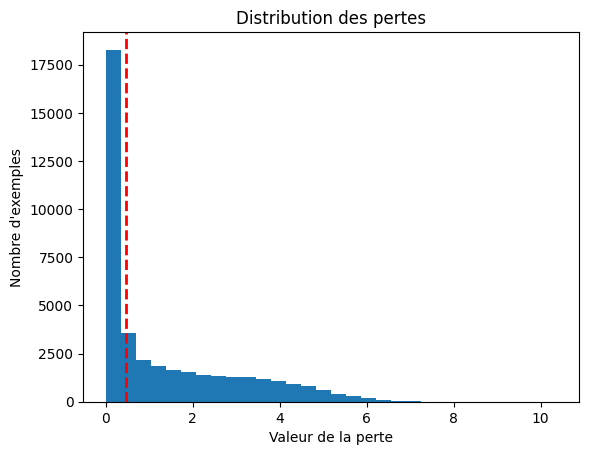

625/625 [==============================] - 235s 376ms/step - loss: 2.1669 - accuracy: 0.6079 - val_loss: 2.4200 - val_accuracy: 0.5234 - lr: 1.0000e-05
Epoch 32/200
625/625 [==============================] - ETA: 0s - loss: 2.1388 - accuracy: 0.6165
Epoch 32: val_loss improved from 2.42003 to 2.41277, saving model to test.h5

🔍 Analyse des hard examples après l'époque 31...
📌 20000 exemples sélectionnés (seuil = 0.4468)
🔍 Analyse des prédictions après l'époque 31:
  - Probabilité moyenne max : 0.6031
  - Écart-type des probas max : 0.3038


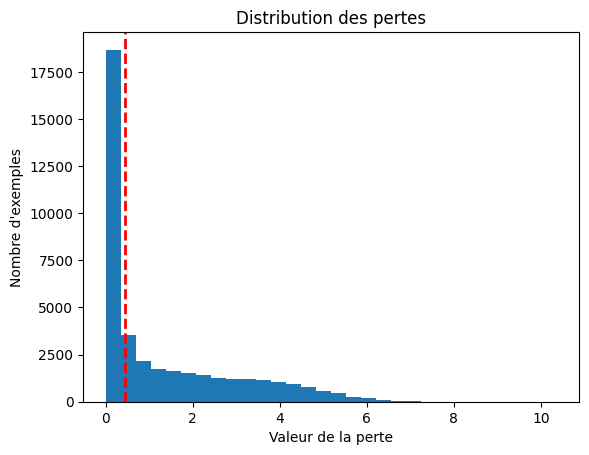

625/625 [==============================] - 236s 378ms/step - loss: 2.1388 - accuracy: 0.6165 - val_loss: 2.4128 - val_accuracy: 0.5241 - lr: 1.0000e-05
Epoch 33/200
625/625 [==============================] - ETA: 0s - loss: 2.1216 - accuracy: 0.6231
Epoch 33: val_loss improved from 2.41277 to 2.40638, saving model to test.h5

🔍 Analyse des hard examples après l'époque 32...
📌 20000 exemples sélectionnés (seuil = 0.4003)
🔍 Analyse des prédictions après l'époque 32:
  - Probabilité moyenne max : 0.6120
  - Écart-type des probas max : 0.3028


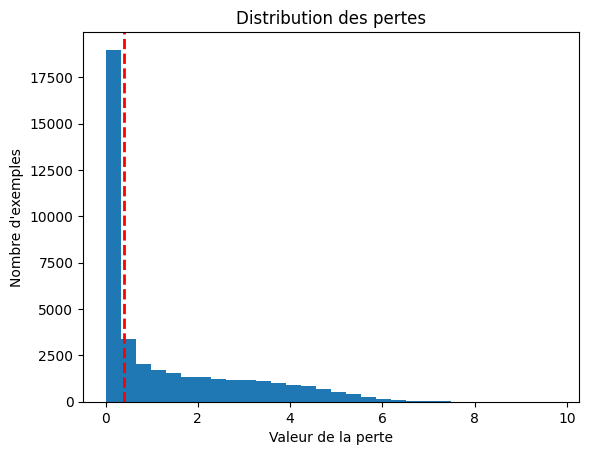

625/625 [==============================] - 231s 370ms/step - loss: 2.1216 - accuracy: 0.6231 - val_loss: 2.4064 - val_accuracy: 0.5295 - lr: 1.0000e-05
Epoch 34/200
625/625 [==============================] - ETA: 0s - loss: 2.1002 - accuracy: 0.6283
Epoch 34: val_loss did not improve from 2.40638

🔍 Analyse des hard examples après l'époque 33...
📌 20000 exemples sélectionnés (seuil = 0.3897)
🔍 Analyse des prédictions après l'époque 33:
  - Probabilité moyenne max : 0.6150
  - Écart-type des probas max : 0.3045


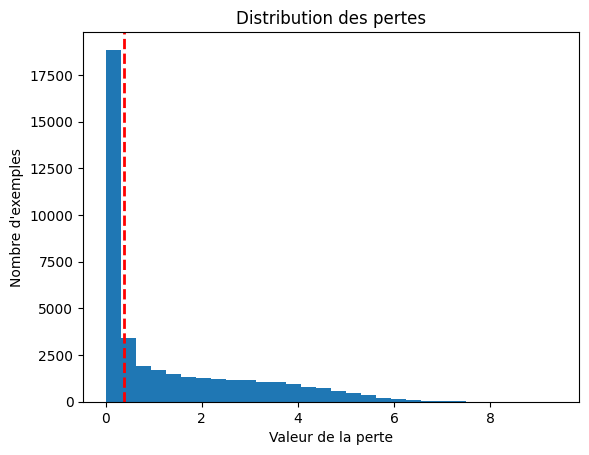

625/625 [==============================] - 232s 372ms/step - loss: 2.1002 - accuracy: 0.6283 - val_loss: 2.4065 - val_accuracy: 0.5281 - lr: 1.0000e-05
Epoch 35/200
625/625 [==============================] - ETA: 0s - loss: 2.0962 - accuracy: 0.6316
Epoch 35: val_loss did not improve from 2.40638

🔍 Analyse des hard examples après l'époque 34...
📌 20000 exemples sélectionnés (seuil = 0.3652)
🔍 Analyse des prédictions après l'époque 34:
  - Probabilité moyenne max : 0.6177
  - Écart-type des probas max : 0.3013


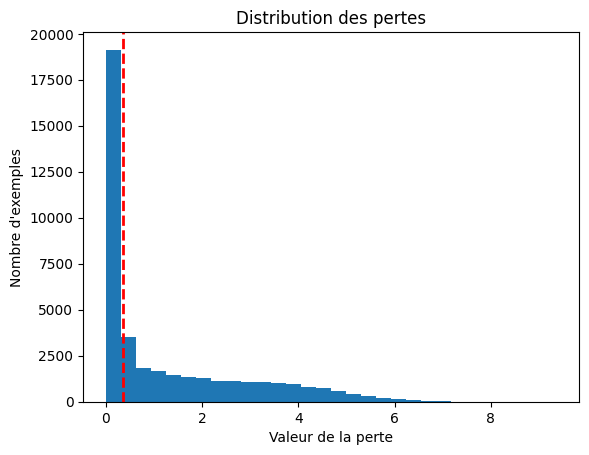

625/625 [==============================] - 221s 353ms/step - loss: 2.0962 - accuracy: 0.6316 - val_loss: 2.4065 - val_accuracy: 0.5283 - lr: 1.0000e-05
Epoch 36/200
625/625 [==============================] - ETA: 0s - loss: 2.0709 - accuracy: 0.6385
Epoch 36: val_loss did not improve from 2.40638

🔍 Analyse des hard examples après l'époque 35...
📌 20000 exemples sélectionnés (seuil = 0.3418)
🔍 Analyse des prédictions après l'époque 35:
  - Probabilité moyenne max : 0.6246
  - Écart-type des probas max : 0.3020


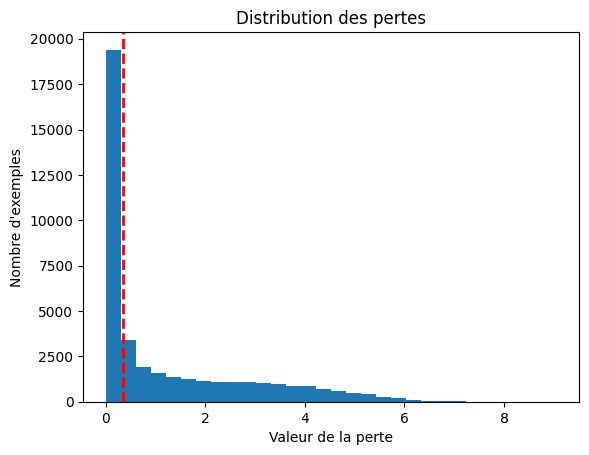

625/625 [==============================] - 224s 358ms/step - loss: 2.0709 - accuracy: 0.6385 - val_loss: 2.4090 - val_accuracy: 0.5331 - lr: 1.0000e-05
Epoch 37/200
625/625 [==============================] - ETA: 0s - loss: 2.0642 - accuracy: 0.6433
Epoch 37: val_loss did not improve from 2.40638

🔍 Analyse des hard examples après l'époque 36...
📌 20000 exemples sélectionnés (seuil = 0.3487)
🔍 Analyse des prédictions après l'époque 36:
  - Probabilité moyenne max : 0.6249
  - Écart-type des probas max : 0.3023


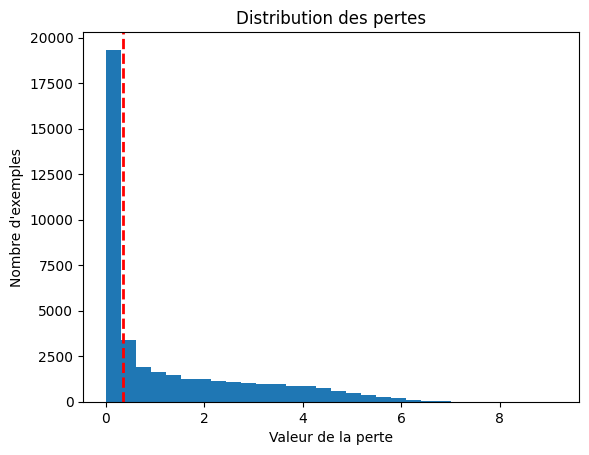

625/625 [==============================] - 230s 369ms/step - loss: 2.0642 - accuracy: 0.6433 - val_loss: 2.4089 - val_accuracy: 0.5325 - lr: 1.0000e-06
Epoch 38/200
625/625 [==============================] - ETA: 0s - loss: 2.0557 - accuracy: 0.6439
Epoch 38: val_loss improved from 2.40638 to 2.40495, saving model to test.h5

🔍 Analyse des hard examples après l'époque 37...
📌 20000 exemples sélectionnés (seuil = 0.3632)
🔍 Analyse des prédictions après l'époque 37:
  - Probabilité moyenne max : 0.6198
  - Écart-type des probas max : 0.3019


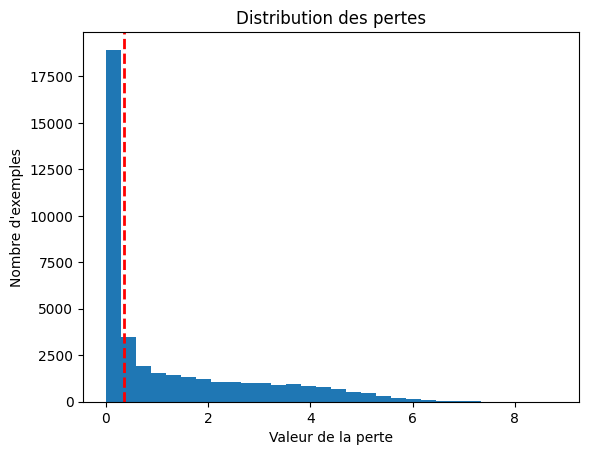

625/625 [==============================] - 215s 345ms/step - loss: 2.0557 - accuracy: 0.6439 - val_loss: 2.4050 - val_accuracy: 0.5333 - lr: 1.0000e-06
Epoch 39/200
625/625 [==============================] - ETA: 0s - loss: 2.0588 - accuracy: 0.6429
Epoch 39: val_loss improved from 2.40495 to 2.40411, saving model to test.h5

🔍 Analyse des hard examples après l'époque 38...
📌 20000 exemples sélectionnés (seuil = 0.3406)
🔍 Analyse des prédictions après l'époque 38:
  - Probabilité moyenne max : 0.6261
  - Écart-type des probas max : 0.3016


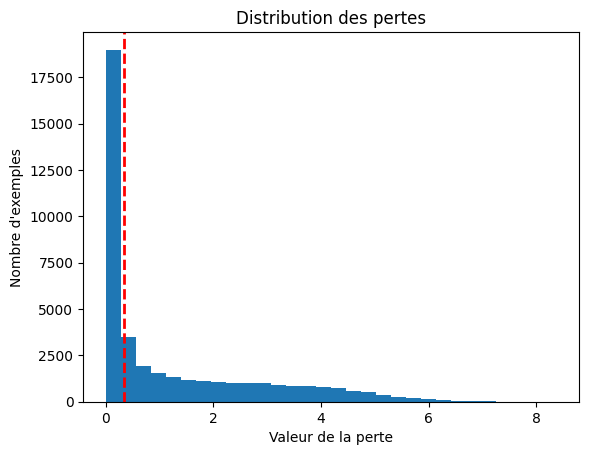

625/625 [==============================] - 227s 364ms/step - loss: 2.0588 - accuracy: 0.6429 - val_loss: 2.4041 - val_accuracy: 0.5346 - lr: 1.0000e-06
Epoch 40/200
625/625 [==============================] - ETA: 0s - loss: 2.0539 - accuracy: 0.6431
Epoch 40: val_loss did not improve from 2.40411

🔍 Analyse des hard examples après l'époque 39...
📌 20000 exemples sélectionnés (seuil = 0.3469)
🔍 Analyse des prédictions après l'époque 39:
  - Probabilité moyenne max : 0.6236
  - Écart-type des probas max : 0.3032


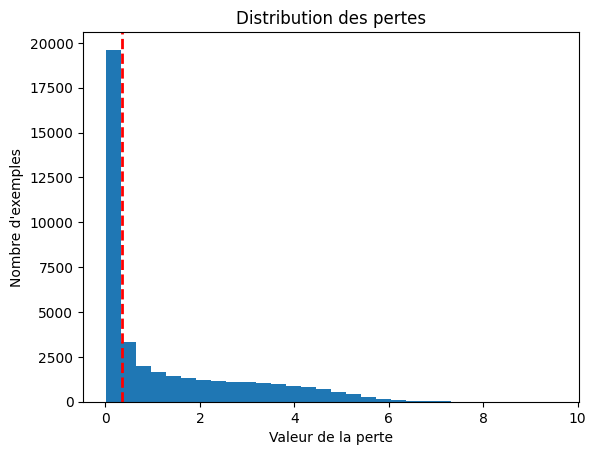

625/625 [==============================] - 238s 381ms/step - loss: 2.0539 - accuracy: 0.6431 - val_loss: 2.4043 - val_accuracy: 0.5351 - lr: 1.0000e-06
Epoch 41/200
625/625 [==============================] - ETA: 0s - loss: 2.0518 - accuracy: 0.6421
Epoch 41: val_loss did not improve from 2.40411

🔍 Analyse des hard examples après l'époque 40...
📌 20000 exemples sélectionnés (seuil = 0.3399)
🔍 Analyse des prédictions après l'époque 40:
  - Probabilité moyenne max : 0.6261
  - Écart-type des probas max : 0.3016


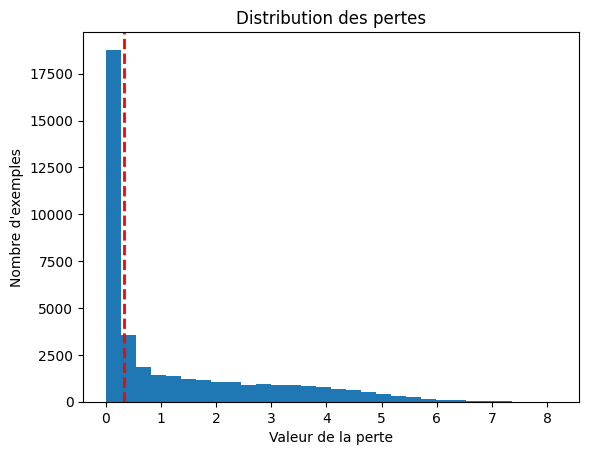

625/625 [==============================] - 235s 377ms/step - loss: 2.0518 - accuracy: 0.6421 - val_loss: 2.4071 - val_accuracy: 0.5339 - lr: 1.0000e-06
Epoch 42/200
625/625 [==============================] - ETA: 0s - loss: 2.0533 - accuracy: 0.6429
Epoch 42: val_loss did not improve from 2.40411

🔍 Analyse des hard examples après l'époque 41...
📌 20000 exemples sélectionnés (seuil = 0.3349)
🔍 Analyse des prédictions après l'époque 41:
  - Probabilité moyenne max : 0.6276
  - Écart-type des probas max : 0.3017


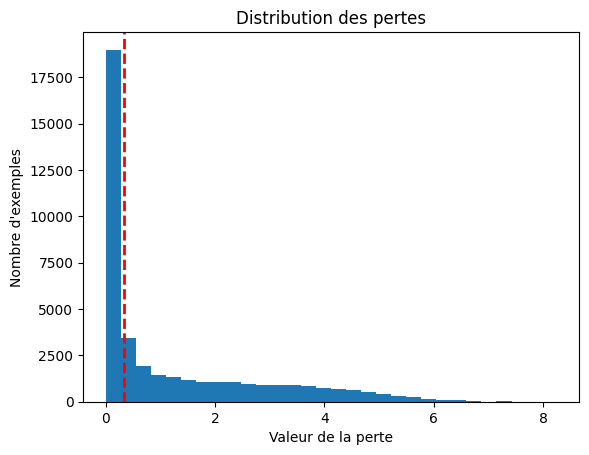

625/625 [==============================] - 230s 368ms/step - loss: 2.0533 - accuracy: 0.6429 - val_loss: 2.4054 - val_accuracy: 0.5337 - lr: 1.0000e-06
Epoch 43/200
625/625 [==============================] - ETA: 0s - loss: 2.0438 - accuracy: 0.6474
Epoch 43: val_loss did not improve from 2.40411

🔍 Analyse des hard examples après l'époque 42...
📌 20000 exemples sélectionnés (seuil = 0.3426)
🔍 Analyse des prédictions après l'époque 42:
  - Probabilité moyenne max : 0.6275
  - Écart-type des probas max : 0.3015


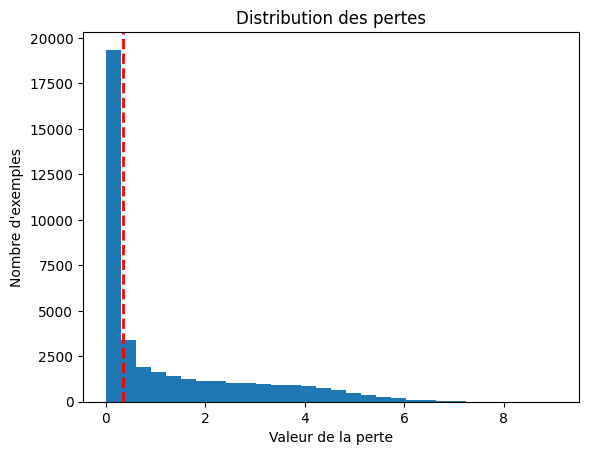

625/625 [==============================] - 235s 377ms/step - loss: 2.0438 - accuracy: 0.6474 - val_loss: 2.4048 - val_accuracy: 0.5334 - lr: 1.0000e-07
Epoch 44/200
625/625 [==============================] - ETA: 0s - loss: 2.0477 - accuracy: 0.6462
Epoch 44: val_loss did not improve from 2.40411

🔍 Analyse des hard examples après l'époque 43...
📌 20000 exemples sélectionnés (seuil = 0.3319)
🔍 Analyse des prédictions après l'époque 43:
  - Probabilité moyenne max : 0.6285
  - Écart-type des probas max : 0.3023


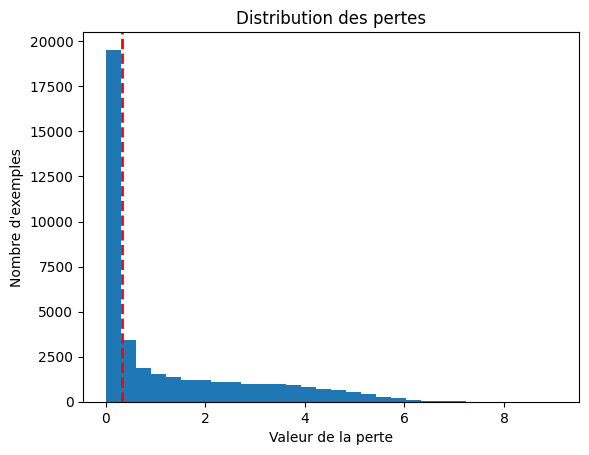

625/625 [==============================] - 241s 385ms/step - loss: 2.0477 - accuracy: 0.6462 - val_loss: 2.4049 - val_accuracy: 0.5341 - lr: 1.0000e-07
Epoch 45/200
625/625 [==============================] - ETA: 0s - loss: 2.0529 - accuracy: 0.6450
Epoch 45: val_loss did not improve from 2.40411

🔍 Analyse des hard examples après l'époque 44...
📌 20000 exemples sélectionnés (seuil = 0.3421)
🔍 Analyse des prédictions après l'époque 44:
  - Probabilité moyenne max : 0.6257
  - Écart-type des probas max : 0.3029


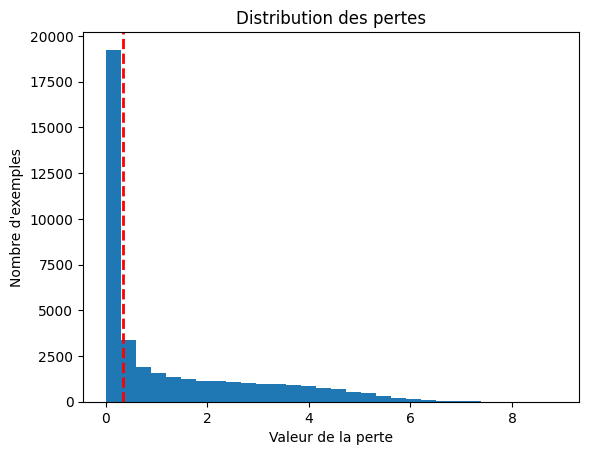

625/625 [==============================] - 232s 372ms/step - loss: 2.0529 - accuracy: 0.6450 - val_loss: 2.4051 - val_accuracy: 0.5336 - lr: 1.0000e-07
Epoch 46/200
625/625 [==============================] - ETA: 0s - loss: 2.0475 - accuracy: 0.6474
Epoch 46: val_loss did not improve from 2.40411

🔍 Analyse des hard examples après l'époque 45...


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [17]:
model, callback = neural_net(num_neurones=512, num_hidden_layers=3, 
                            dropout_rate=0.4, early_stop_patience=8, 
                            lr_scheduler_patience=3, train_generator=train_generator,
                            learning_rate= 0.0001)

history = training(model=model, cb= callback, n_epoch=200)

plot_history(history=history)

In [18]:
p_test = pre_process(test)
test_labels = test[b'fine_labels']

In [19]:
test_generator = create_test_generator(p_test, test_labels, batch_size=64)

In [20]:
model = load_model("test.h5")

In [21]:
model.evaluate(test_generator)

156/156 [==============================] - 3s 12ms/step - loss: 2.4075 - accuracy: 0.5320


[2.4075326919555664, 0.5319511294364929]